In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import folium

# Load, merge and save shape data of germany and the exculsive exonomic zone

In [2]:
# Load the shape of germany, set the crs and display the file for inspection
raw_shape_ger = gpd.read_file("../data/DEU_adm1.shp")
print(raw_shape_ger.crs)
raw_shape_ger = raw_shape_ger[:].to_crs('EPSG:4326')
raw_shape_ger.head()

epsg:4326


,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,86,DEU,Germany,1,Baden-Württemberg,Land,State,None,None,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7..."
1,86,DEU,Germany,2,Bayern,Land,State,None,Bavaria,"POLYGON ((10.13386 50.55000, 10.13980 50.54252..."
2,86,DEU,Germany,3,Berlin,Land,State,None,None,"POLYGON ((13.17789 52.39032, 13.16575 52.39050..."
3,86,DEU,Germany,4,Brandenburg,Land,State,None,None,"POLYGON ((13.87951 53.50107, 13.87927 53.49908..."
4,86,DEU,Germany,5,Bremen,Land,State,None,None,"MULTIPOLYGON (((8.50506 53.23289, 8.51754 53.2..."


In [3]:
# Load the shape of exclusive exonomic zone (baltic and north sea), set the crs and display the file for inspection
raw_shape_ger_eez = gpd.read_file("../data/eez.shp")
print(raw_shape_ger_eez.crs)
raw_shape_ger_eez = raw_shape_ger_eez.to_crs('EPSG:4326')
raw_shape_ger_eez.head()

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


,mrgid,geoname,mrgid_ter1,pol_type,mrgid_sov1,territory1,iso_ter1,sovereign1,mrgid_ter2,mrgid_sov2,...,iso_sov1,iso_sov2,iso_sov3,un_sov1,un_sov2,un_sov3,un_ter1,un_ter2,un_ter3,geometry
0,5669,German Exclusive Economic Zone,2101,200NM,2101,Germany,DEU,Germany,0,0,...,DEU,None,None,276.0,None,None,276.0,None,None,"MULTIPOLYGON (((14.09923 53.86999, 14.11579 53..."


/home/niko/RenewableEnergyForecastML/python_venv_renew/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


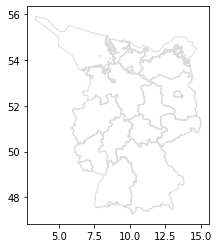

In [4]:
# Drop not needed rows, merge both geodataframes, plot a map and save as shape file
shape_ger = raw_shape_ger[['NAME_1', 'geometry']].rename(columns = {'NAME_1':'geoname'})
shape_ger_eez = raw_shape_ger_eez[['geoname', 'geometry']]
shape_ger_complete = pd.concat([shape_ger, shape_ger_eez]).reset_index(drop=True)
ax = shape_ger_complete.plot(color="none", edgecolor='gainsboro')

shape_ger_complete.to_file("../data/shape_ger_complete.shp")

# Download and join weather data of germany and surrounding

In [5]:
# years that are to be investigated
#years = [2019,2020,2021,2022]
years = [2015,2016,2017,2018,2019,2020,2021,2022]

In [6]:
# download the weather data
# this is split into east and west, because the API only allows 10° LAT and LON
# and into years, because the API only allows 366 days in one download

import requests

for year in years:
    if year == 2022:
        mmdd = '0401'
    else:
        mmdd = '1231'
    url = 'https://power.larc.nasa.gov/api/temporal/daily/regional?parameters=T2M,T2MDEW,T2MWET,TS,WS50M,WD50M,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_UVA,ALLSKY_SFC_UVB&start='+str(year)+'0101&end='+str(year)+mmdd+'&community=RE&format=CSV&latitude-min=47.25&latitude-max=56.25&longitude-min=3.25&longitude-max=10.25'
    data = requests.get(url, allow_redirects=True)
    open('../data/weather_map_raw_ger_west_'+str(year)+'.csv', 'wb').write(data.content)

    url = 'https://power.larc.nasa.gov/api/temporal/daily/regional?parameters=T2M,T2MDEW,T2MWET,TS,WS50M,WD50M,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_UVA,ALLSKY_SFC_UVB&start='+str(year)+'0101&end='+str(year)+mmdd+'&community=RE&format=CSV&latitude-min=47.25&latitude-max=56.25&longitude-min=10.75&longitude-max=15.25'
    data = requests.get(url, allow_redirects=True)
    open('../data/weather_map_raw_ger_east_'+str(year)+'.csv', 'wb').write(data.content)

In [7]:
# merge east and west and all years to one file

weather_raw_ger = {}

for year in years:
    weather_raw_ger_east = pd.read_csv("../data/weather_map_raw_ger_east_"+str(year)+".csv",
                                           header=19)
    weather_raw_ger_west = pd.read_csv("../data/weather_map_raw_ger_west_"+str(year)+".csv",
                                           header=19)
    
    weather_raw_ger[year] = pd.concat([weather_raw_ger_east,
                                                weather_raw_ger_west])

weather_raw_ger = pd.concat([weather_raw_ger[year] for year in years]).reset_index(drop=True)

In [8]:
# infer the date to a pandas datetime (therefore rename stuff..)

weather_raw_ger.rename(columns = {'MO':'month', 'DY':'day'}, inplace=True)
weather_raw_ger['date'] = pd.to_datetime(weather_raw_ger[['YEAR', 'month', 'day']])
weather_raw_ger.drop(['YEAR', 'month', 'day'], axis=1, inplace=True)
#weather_ger.set_index(['date'])
weather_raw_ger

,LAT,LON,T2M,T2MDEW,T2MWET,TS,WS50M,WD50M,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_UVA,ALLSKY_SFC_UVB,date
0,47.25,10.75,-5.85,-8.05,-6.95,-12.37,1.89,193.22,1.69,1.71,253.09,3.45,0.03,2015-01-01
1,47.25,11.25,-7.01,-8.07,-7.54,-11.26,2.06,239.34,1.69,1.71,253.09,3.45,0.03,2015-01-01
2,47.25,11.75,-7.20,-7.85,-7.52,-11.01,1.99,258.42,1.69,1.71,253.09,3.45,0.03,2015-01-01
3,47.25,12.25,-6.84,-7.43,-7.14,-10.30,1.93,252.76,1.16,1.67,264.00,2.48,0.02,2015-01-01
4,47.25,12.75,-6.39,-7.01,-6.70,-9.63,1.98,253.82,1.16,1.67,264.00,2.48,0.02,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257795,56.25,8.25,2.45,-2.23,0.11,3.25,7.61,43.54,3.56,-999.00,232.10,-999.00,-999.00,2022-04-01
1257796,56.25,8.75,1.20,-2.88,-0.84,1.40,7.41,41.94,3.56,-999.00,232.10,-999.00,-999.00,2022-04-01
1257797,56.25,9.25,0.70,-3.20,-1.25,0.72,7.24,40.49,3.56,-999.00,232.10,-999.00,-999.00,2022-04-01
1257798,56.25,9.75,0.87,-3.19,-1.16,0.97,6.94,40.65,3.56,-999.00,232.10,-999.00,-999.00,2022-04-01


<AxesSubplot:>

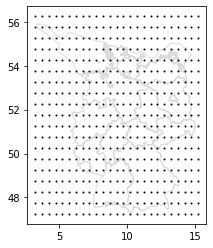

In [9]:
# convert weather data to a geodataframe (with LON and LAT) so its easy to inspect
# plot the shape file and the weather data locations (only for one datetime, locations are the same for all datetimes)

weather_raw_ger_geo = gpd.GeoDataFrame(weather_raw_ger,
                                       geometry = gpd.points_from_xy(weather_raw_ger.LON, weather_raw_ger.LAT),
                                       crs="EPSG:4326")

ax = shape_ger_complete.plot(color="none", edgecolor='gainsboro')
weather_raw_ger_geo[weather_raw_ger['date'] == pd.Timestamp('2019-01-01')].plot(color="k", markersize=1, ax=ax)

# Select datapoints within germany

In [10]:
# Sort the data for a computationally efficent application of the mask

weather_raw_ger = weather_raw_ger.sort_values(by=['date', 'LAT', 'LON']).reset_index(drop=True)
weather_raw_ger_geo = weather_raw_ger_geo.sort_values(by=['date', 'LAT', 'LON']).reset_index(drop=True)

In [26]:
# for one specific datetime generate a mask of weather locations that are within germany and eez

mask_individual_shape = [weather_raw_ger_geo[weather_raw_ger['date'] == pd.Timestamp('2019-01-01')].within(shape_ger_complete.loc[i, 'geometry']) for i in range(len(shape_ger_complete))]
mask_individual_time = pd.Series([any([mask_individual_shape[i].iloc[j] for i in range(len(mask_individual_shape))]) for j in range(len(mask_individual_shape[0]))])

In [27]:
# expand this mask by concatinating copys of it

mask = mask_individual_time.copy()
mask_t = mask_individual_time.copy()
for i in range(int(len(weather_raw_ger)/len(mask_individual_time)-1)):
    mask_t.index += len(mask_individual_time)
    mask = pd.concat([mask, mask_t])

<AxesSubplot:>

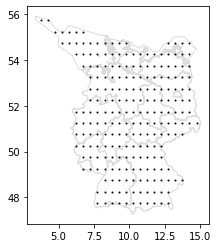

In [28]:
# Apply the mask and plot the result for a single datetime

self.weather_ger_geo = weather_raw_ger_geo[mask].reset_index(drop=True)

ax = shape_ger_complete.plot(color="none", edgecolor='gainsboro')
self.weather_ger_geo[self.weather_ger_geo['date'] == pd.Timestamp('2019-07-04')].plot(color="k", markersize=1, ax=ax)

In [35]:
# Locate NaN values (which are marked by -999)

weather_ger_df_nan = (self.weather_ger_geo[self.weather_ger_geo.eq(-999).any(axis=1)])
pd.to_datetime(pd.unique(weather_ger_df_nan.date))

DatetimeIndex(['2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11',
               '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15',
               '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19',
               '2022-01-20', '2022-01-21', '2022-01-22', '2022-01-23',
               '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27',
               '2022-01-28', '2022-01-29', '2022-01-30', '2022-01-31',
               '2022-02-01', '2022-02-02', '2022-02-03', '2022-02-04',
               '2022-02-05', '2022-02-06', '2022-02-07', '2022-02-08',
               '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-12',
               '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16',
               '2022-02-17', '2022-02-18', '2022-02-19', '2022-02-20',
               '2022-02-21', '2022-02-22', '2022-02-23', '2022-02-24',
               '2022-02-25', '2022-02-26', '2022-02-27', '2022-02-28',
               '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04',
      

In [36]:
# Only days in 2022 contain NaN values, so 2022 will be omitted
weather_ger_df = pd.DataFrame(self.weather_ger_geo.drop(columns='geometry')[self.weather_ger_geo.date.dt.year != 2022])

In [37]:
# Quick check if weather data is plausible

from folium.plugins import HeatMap, MarkerCluster

# Create a base map
f_map = folium.Map(location=[51,10], tiles='cartodbpositron', zoom_start=5)

# Add a heatmap to the base map
HeatMap(data=self.weather_ger_geo[self.weather_ger_geo['date'] == pd.Timestamp('2019-07-04')][['LAT','LON','WS50M']]).add_to(f_map)
f_map

In [38]:
# Energy generation data will only be available for whole germany, therefore each row has to contain all LAT LON information.
# Generate feature map by translating LAT LON from columns to single row:

lat_lon = weather_ger_df[['LAT', 'LON']].drop_duplicates()
column_names = []
for i in weather_ger_df.columns[2:-1]:
    for index, row in lat_lon.iterrows():
        column_names.append(i+' '+str(row['LAT'])+' '+str(row['LON']))
column_names.append('date')

# Correct way but very slow
#for date in pd.unique(weather_ger_df.date):
#    for index, row in lat_lon.iterrows():
#        weather_ger_df[(weather_ger_df.date == date) & (weather_ger_df.LAT == row['LAT']) & (weather_ger_df.LON == row['LON'])] ...

# A bit hacky, but correct and fast:

weather_ger_reshape = pd.DataFrame(columns = column_names, index=np.arange(len(pd.unique(weather_ger_df.date))))
for j in range(len(weather_ger_reshape)):
    for i in range(len(weather_ger_df.columns)-3):
        weather_ger_reshape.loc[j][i*len(lat_lon):(i+1)*len(lat_lon)] = weather_ger_df.loc[j*len(lat_lon):(j+1)*len(lat_lon)-1][weather_ger_df.columns[i+2]]
    weather_ger_reshape.loc[j][-1] = weather_ger_df.loc[j*len(lat_lon)].date
weather_ger_reshape.set_index('date', inplace=True)

# Load data of renewable energy production and locate NaN values

In [40]:
# years that are to be investigated (defined before, just execute if you jumped in here)
#years = [2019,2020,2021,2022]
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [107]:
electricity_raw = {}

for year in years:
    if year <= 2019:
        electricity_raw[year] = pd.read_csv('../data/energy-charts_Electricity_production_in_Germany_in_'+str(year)+'.csv')
    else:
        electricity_raw[year] = pd.read_csv('../data/energy-charts_Electricity_generation_in_Germany_in_'+str(year)+'.csv')

electricity_raw = pd.concat([electricity_raw[year] for year in years]).reset_index(drop=True)
electricity_raw['Date (UTC)'] = pd.to_datetime(electricity_raw['Date (UTC)'], utc=True)
electricity_raw.set_index(['Date (UTC)'], inplace = True)
electricity_raw.index = electricity_raw.index.tz_convert(None)

def power_to_energy(power_single_day):
    measurements_per_hour = len(power_single_day)/24
    energy = np.sum(power_single_day) / measurements_per_hour
    return  energy

electricity_raw_daybinned = electricity_raw.resample('D').apply(power_to_energy)

#electricity_nan = electricity_raw[electricity_raw.isnull().any(axis=1)]
#electricity_raw_daybinned.loc[pd.to_datetime(pd.unique(electricity_nan.index.date))]

In [108]:
#electricity_raw_daybinned = electricity_raw_daybinned.drop(pd.to_datetime(pd.unique(electricity_nan.index.date)))
#electricity_raw_daybinned = electricity_raw_daybinned[electricity_raw_daybinned.index.year != 2022]

electricity_daybinned = pd.DataFrame(index = electricity_raw_daybinned.index)
electricity_daybinned['Wind'] = electricity_raw_daybinned[electricity_raw_daybinned.columns[0:6]].sum(axis=1)
electricity_daybinned['Solar'] = electricity_raw_daybinned[electricity_raw_daybinned.columns[6:-1]].sum(axis=1)

electricity_daybinned.index.names = ['date']

In [110]:
#weather_ger_reshape_merge = weather_ger_reshape.drop(pd.to_datetime(pd.unique(electricity_nan.index.date)), errors = 'ignore')
#weather_electricity_data = pd.merge(left = weather_ger_reshape_merge, right = electricity_daybinned, how='left', on = 'date')
#weather_electricity_data

weather_electricity_data = pd.merge(left = weather_ger_reshape, right = electricity_daybinned, how='left', on = 'date')
weather_electricity_data

,T2M 47.75 7.75,T2M 47.75 8.25,T2M 47.75 8.75,T2M 47.75 9.25,T2M 47.75 9.75,T2M 47.75 10.25,T2M 47.75 10.75,T2M 47.75 11.25,T2M 47.75 11.75,T2M 47.75 12.25,...,ALLSKY_SFC_UVB 54.75 14.25,ALLSKY_SFC_UVB 55.25 4.75,ALLSKY_SFC_UVB 55.25 5.25,ALLSKY_SFC_UVB 55.25 5.75,ALLSKY_SFC_UVB 55.25 6.25,ALLSKY_SFC_UVB 55.25 6.75,ALLSKY_SFC_UVB 55.75 3.75,ALLSKY_SFC_UVB 55.75 4.25,Wind,Solar
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,-4.83,-5.42,-5.24,-5.87,-5.67,-5.4,-5.39,-5.59,-5.72,-5.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,324.26600,17.34800
2015-01-02,-2.0,-2.5,-2.32,-1.84,-1.43,-0.94,-0.52,-0.62,-0.73,-0.44,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,613.53500,7.86400
2015-01-03,1.35,0.58,1.1,1.12,0.81,0.33,-0.16,-0.56,-0.39,-0.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,472.53200,7.39800
2015-01-04,-0.08,-0.56,-0.86,-0.97,-1.59,-2.24,-2.57,-2.42,-2.28,-2.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,394.79400,19.93000
2015-01-05,-1.18,-1.69,-1.79,-2.55,-3.59,-4.26,-4.3,-3.82,-3.97,-4.1,...,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,222.71800,25.93800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.87,3.48,3.24,3.11,2.92,2.52,1.94,1.38,0.54,0.44,...,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,346.46125,80.81100
2021-12-28,6.63,5.72,5.09,4.44,3.83,3.3,2.88,2.56,1.91,1.55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,379.57525,143.17175
2021-12-29,7.06,6.12,5.83,5.14,4.54,4.09,3.79,3.65,3.33,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.74050,126.47050


In [111]:
# save data as da pandas dataframe
weather_electricity_data.to_csv("../data/weather_electricity_data.csv")